## Analysing the experimentla data of  [Brydges et al, Science 2019](https://doi.org/10.1126/science.aau4963)

In [9]:
using ITensors
using RandomMeas
using ProgressMeter
using MAT

In [10]:
## parameters 
N = 10 # System size
times = [0,1,2,3,4,5] # quench times in ms
ntimes = length(times)  # number of time points
ξ = siteinds("Qubit", N); # site indices of the shadows

# Parameters specifying the Renyi entropies of interest
n = 6 # maximal Renyi index (n-th Renyi entropy)
NAmax = 6; #maximal subsystem size. We always consider subsystems of the form [1,2,...,NA].

We now load the experimental randomized measurement data obtained in Brydges et al., Science 2018.

In [11]:
NU, NM = 500,150 # number of unitaries and measurements per unitary

data = zeros(Int,ntimes,NU,NM,N); # data array containgin the measurement results

u = Vector{Vector{Vector{ITensor}}}()
for s in 1:ntimes
    vars = matread("BrydgesScience2019data/unitaries_10_T_" * string(times[s]) * "_flr_1.mat")
    raw_measurements = vars["qstates" * string(times[s])]

    for r in 1:NU
        for m in 1:NM
            data[s,r,m,:] = reverse(digits(floor(Int,raw_measurements[r,m]), base=2, pad=N) .+ 1)
        end
    end    
    
    ut = Vector{Vector{ITensor}}()
    for r in 1:NU
        push!(ut,[ITensor(vars["unitaries"][r,i],ξ[i]',ξ[i]) for i in 1:N])
    end
    push!(u,ut)
end

We estimate the purity using the direct purity estimation formula presented Brydges et al., Science 2019 and using classical shadows Huang et al., Nat. Phys. 2020.

In [17]:
p_direct = zeros(Float64,ntimes,NAmax)
p_shadow = zeros(Float64,ntimes,NAmax)
@showprogress for s in 1:ntimes
    for NA in 1:NAmax
        uA = [ut[1:NA] for ut in u[s]]
        p_direct[s,NA] = get_purity_hamming(data[s,:,:,1:NA],ξ[1:NA]) 
        p_shadow[s,NA] = get_purity_shadows(data[s,:,:,1:NA],uA,ξ[1:NA])
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:53


We estimate higher order Renyi entropies (up to order n) using batch shadows (c.f. Rath et al., PRXQ 2023).

In [18]:
#Tr(rho^n) and Renyis from batch shadows
p_bshadow = zeros(Float64,ntimes,NAmax,n-1)
S_bshadow = zeros(Float64,ntimes,NAmax,n-1)
@showprogress for s in 1:ntimes
    for NA in 1:NAmax
        uA = [ut[1:NA] for ut in u[s]]
        ξA = ξ[1:NA]
        ρs = get_batch_shadows(data[s,:,:,1:NA],ξA,uA,n)
        p_bshadow[s,NA,:] = get_moments(ρs, ξA, n)
        for nt in 2:n
            S_bshadow[s,NA,nt-1]= log2(p_bshadow[s,NA,nt-1])/(1-nt)
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:26


Finally, we load quantum states generated by classical simulations (master equation evolution) of the experiment, including a decoherence model. We compute Renyi entropies.

In [14]:
ρ = Vector{ITensor}()
p = zeros(Float64,ntimes,NAmax,n-1)
S = zeros(Float64,ntimes,NAmax,n-1)
SvN = zeros(Float64,ntimes,NAmax)
ITensors.disable_warn_order()

for s in 1:ntimes
    qstate = matread("BrydgesScience2019data/rho_10_XY_10_-1.00_0.00"*string(times[s])*"_1_1_1_flr_1.mat")["rho"]
    qstate = reshape(qstate,tuple((2*ones(Int,2*N))...))
    push!(ρ,ITensor(qstate,vcat(ξ',ξ)))
    for NA in 1:NAmax
        A = collect(1:NA)
        ρA = copy(ρ[s])
        for i in 1:N
            if !(i in A)
                ρA *= δ(ξ[i],ξ[i]') 
            end
        end
        for nt in 2:n
            p[s,NA,nt-1] = real(trace(power(ρA,nt),ξ[1:NA]))
            S[s,NA,nt-1]= log2(p[s,NA,nt-1])/(1-nt)
        end
        D, = eigen(ρA,ξ[1:NA]',ξ[1:NA];ishermitian=true)
        for k in 1:2^NA
            if D[k,k]>1e-12
                SvN[s,NA] -= D[k,k]*log2(D[k,k])
            end
        end
    end
end

We plot the purity as a function of NA for the different times.

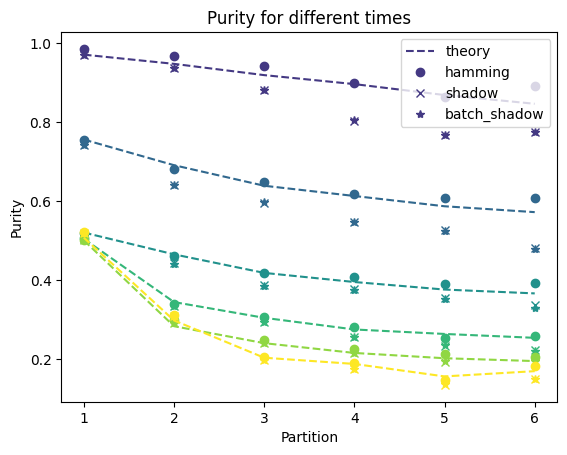

In [20]:
using PyPlot

clf()

cm = get_cmap(:viridis)
for s in 1:ntimes
    plot(1:NAmax,p[s,:,1],"--",color=cm(s/ntimes))
    plot(1:NAmax,p_direct[s,:],"o",color=cm(s/ntimes))
    plot(1:NAmax,p_shadow[s,:],"x",color=cm(s/ntimes))
    plot(1:NAmax,p_bshadow[s,:,1],"*",color=cm(s/ntimes))
end
#yscale("log")
xlabel("Partition")
ylabel("Purity")
legend(["theory","hamming","shadow","batch_shadow"])
title("Purity for different times")

gcf()

We plot the higher order Renyi entropies as a function of Renyi index n for a fixed subystem size and various times.

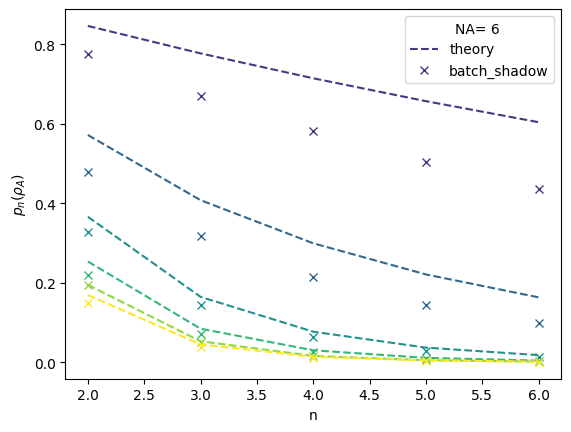

In [21]:
using PyPlot

clf()

NA = 6
for s in 1:1
    plot(2:n,p[s,NA,:],"--",color=cm(s/ntimes),label="theory")
    plot(2:n,p_bshadow[s,NA,:],"x",color=cm(s/ntimes),label="batch_shadow")
end
for s in 2:ntimes
    plot(2:n,p[s,NA,:],"--",color=cm(s/ntimes))
    plot(2:n,p_bshadow[s,NA,:],"x",color=cm(s/ntimes))
end
xlabel("n")
ylabel(L"p_n(\rho_A)")
legend(title = "NA= $NA ")

gcf()

## The following code is not yet optimized. It computes error bars via Jackknife and can be slow.

In [17]:
#Tr(rho^n) and Renyis from batch shadows
p_bshadow_jk = zeros(Float64,NU,ntimes,NAmax,n-1)
S_bshadow_jk = zeros(Float64,NU,ntimes,NAmax,n-1)

function find_group(vector_of_vectors, i)
    for (index, vec) in pairs(vector_of_vectors)
        if i in vec
            return index, length(vec)
        end
    end
    return nothing, 0  # Return nothing and size 0 if the integer is not found
end

function get_batches(data::Array{Int8}, n::Int64)
    batches = Vector{Vector{Int}}()
    NU = size(data, 1)
    NU_n = NU ÷ n
    for t in 1:n
        push!(batches,collect(1+(t-1)*NU_n:t*NU_n))
    end
    return batches
end

for s in ProgressBar(1:ntimes, printing_delay=2)
    for NA in 1:NAmax
            @show s,NA
            uA = [ut[1:NA] for ut in u[s]]
            ξA = ξ[1:NA]
            ρs = get_batch_shadows(data[s,:,:,1:NA],ξA,uA,n)
            batches = get_batches(data[s,:,:,1:NA],n) # A vector of vectors, specifying which shadow in which batch 
            for r in 1:batches[end][end]
                ρr = get_batch_shadows(reshape(data[s,r,:,1:NA],1,NM,NA),ξA,[uA[r]],1) # get the shadow of r
                batch,batch_size = find_group(batches,r) # find the batch of shadow r
                ρs_r = copy(ρs) 
                ρs_r[batch] = ((ρs_r[batch]*batch_size)-ρr[1])/(batch_size-1) # substract shadow r from the correct batch shadow
                p_bshadow_jk[r,s,NA,:] = get_moments(ρs_r, ξA, n) # do the estimation of shadow r removed
                for nt in 2:n
                    S_bshadow_jk[r,s,NA,nt-1]= log2(p_bshadow_jk[r,s,NA,nt-1])/(1-nt)
                end
            end
    end
end

In [ ]:
#Optional saving and loading of the data

#using NPZ
#npzwrite("jk_brydges.npz",Dict("p_bshadow_jk"=>p_bshadow_jk,"S_bshadow_jk"=>S_bshadow_jk))

#vars = npzread("jk_brydges.npz")
#S_bshadow_jk = vars["S_bshadow_jk"]
#p_bshadow_jk = vars["p_bshadow_jk"]

In [ ]:
using Statistics
size(p_bshadow_jk)
p_bshadow_jk_mean = mean(p_bshadow_jk[1:498,:,:,:],dims=1)
p_bshadow_jk_mean = p_bshadow_jk_mean[1,:,:,:]
S_bshadow_jk_mean = mean(S_bshadow_jk[1:498,:,:,:],dims=1)
S_bshadow_jk_mean = S_bshadow_jk_mean[1,:,:,:]

@show size(p_bshadow_jk_mean) size(p_bshadow)
p_bshadow_jk_bias = 497 * (p_bshadow_jk_mean - p_bshadow)
S_bshadow_jk_bias = 497 * (S_bshadow_jk_mean - S_bshadow)

@show maximum(abs.(p_bshadow_jk_bias)) 
@show maximum(abs.(S_bshadow_jk_bias)) 

p_bshadow_jk_var =497*var(p_bshadow_jk[1:498,:,:,:],dims=1,corrected=false)
p_bshadow_jk_var=p_bshadow_jk_var[1,:,:,:]
S_bshadow_jk_var =497*var(S_bshadow_jk[1:498,:,:,:],dims=1,corrected=false)
S_bshadow_jk_var=S_bshadow_jk_var[1,:,:,:]
@show maximum((p_bshadow_jk_var)) 
@show maximum((S_bshadow_jk_var)) 


In [ ]:
using PyPlot

clf()

cm = get_cmap(:viridis)
for s in 1:ntimes
    plot(1:NAmax,p[s,:,1],"--",color=cm(s/ntimes))
    #plot(1:NAmax,p_hamming[s,:],"o",color=cm(s/ntimes))
    errorbar(1:NAmax,p_bshadow[s,:,1]-p_bshadow_jk_bias[s,:,1],yerr=sqrt.(p_bshadow_jk_var[s,:,1]),fmt="x",color=cm(s/ntimes))

end
#yscale("log")
xlabel("Partition")
ylabel("Purity")
legend(["theory","hamming","shadow","batch_shadow"])
title("Purity for different times")

gcf()

In [ ]:
using PyPlot

clf()

co = ["blue","red","green","magenta","orange","black"]
NA = 6

for s in 1:1
    plot(2:n,S[s,NA,:],"--",color=cm(s/ntimes),label="theory")
    plot([1],[SvN[s,NA]],"o",color=cm(s/ntimes),label="theory SvN")
    plot(2:n,S_bshadow[s,NA,:],"*",color=cm(s/ntimes),label="batch_shadow")
    errorbar(2:n,S_bshadow[s,NA,:]-S_bshadow_jk_bias[s,NA,:],yerr=sqrt.(S_bshadow_jk_var[s,NA,:]),fmt="x",color=cm(s/ntimes),label="batch_shadow_jk")
end
for s in 2:ntimes
    plot(2:n,S[s,NA,:],"--",color=cm(s/ntimes))
    plot([1],[SvN[s,NA]],"o",color=cm(s/ntimes))
    plot(2:n,S_bshadow[s,NA,:],"*",color=cm(s/ntimes))
    errorbar(2:n,S_bshadow[s,NA,:]-S_bshadow_jk_bias[s,NA,:],yerr=sqrt.(S_bshadow_jk_var[s,NA,:]),fmt="x",color=cm(s/ntimes))
end
xlabel("n")
ylabel(L"S_n(\rho_A)")
legend(title = "NA= $NA ")

gcf()